In [369]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import pandas as pd
from tqdm.notebook import tqdm

from scipy.special import softmax
from scipy.spatial.distance import cdist
import numpy as np
import torch

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
from sklearn.model_selection import KFold, ParameterGrid
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

from mlxtend.plotting import plot_decision_regions

In [103]:
df = pd.read_csv("diabetes.csv")
data = df.drop('Outcome', axis = 1)   # Features
labels = df.drop(['Glucose', 'Insulin', 'Pregnancies', 'BloodPressure', 'SkinThickness', 'BMI', 'DiabetesPedigreeFunction', 'Age'], axis = 1)   # Targets

In [248]:
X_train, X_test,Y_train, Y_test = train_test_split(data, labels, test_size = 168, random_state = 0)
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [249]:
# Ядро используется квадратичное (1 - r**2). В случае, если r>1, то K = 0
def K(distance, h = 0.05):
    ret = np.array(distance)/h
    return (1 - ret**2) * (np.abs(ret) <= 1) # (1 - r**2) умножить на бинарную ф-ию. Если r>1, то пропускаем, иначе умножаем

# Инфинитное гауссовское ядро
def K_gauss(distance, h = 0.05):
    ret = np.array(distance)/h
    return (np.exp(-2 * ret**2))

# Финитное треугольное ядро
def K_triangle(distance, h = 0.05):
    ret = np.array(distance)/h
    return (1 - np.abs(ret)) * (np.abs(ret) <= 1)

<h3>Метод потенциальных функций</h3>

In [306]:
class PFM(object):
    def __init__(self, kernel = None):
        self.X, self.Y, self.gams = None, None, None
        self.kernel = lambda x: np.ones_like(x)
        if kernel is not None:
            self.kernel = kernel
    def score(self, X):
        # Размерности: X=(1, кол-во признаков), self.X=(кол-во объектов обуч.выборки, кол-во признаков),
        # self.gams=(кол-во объектов обуч.выборки, ) => w=(1, кол-во объектов) - вектор весов объектов
        w = self.gams.reshape((600,)) * self.kernel(cdist(X, self.X))
        #print(w.shape)
        sum_of_weights_for_zero_class_objects = np.sum(w.T[np.where(self.Y == 0)[0]].T, axis = -1)
        sum_of_weights_for_one_class_objects = np.sum(w.T[np.where(self.Y == 1)[0]].T, axis = -1)
        #print(sum_of_weights_for_zero_class_objects.shape)
        #print(sum_of_weights_for_one_class_objects.shape)
        scores = np.vstack(
            [sum_of_weights_for_zero_class_objects,
            sum_of_weights_for_one_class_objects]).T
        return scores
    
    def predict(self, X):
        # возвращает номер класса, у которого наибольшая сумма весов
        return np.argmax(self.score(X), axis = -1)
    def fit(self, X, Y, epochs = 10):
        # Инициализирую X, Y. Гамму инициализирую массивом нулей размерностью Y
        self.X, self.Y, self.gams = np.array(X), np.array(Y).reshape((np.array(Y).shape[0],)), np.zeros_like(Y.values.reshape((Y.shape[0],)))
        for _ in range(epochs):
            # для каждой пары (объект, ответ): если предсказание неверно, значение соответствующей гаммы увел. на единицу
            for i, (x, y) in enumerate(zip(self.X, self.Y)):
                if self.predict(np.array([x]))[0] != y:
                    self.gams[i] += 1

In [307]:
model = PFM(kernel = lambda x: K_triangle(x, h = 15))
model.fit(X_train, Y_train)

In [308]:
# M - margin. Равен сумме весов верного класса(s[y]) минус сумма весов неверного класса(s[y-1])
M = [s[y] -s[y-1] for s, y in zip(model.score(X_train), Y_train.values)]
# Отсортирую массив отступов по возрастанию для графика
M = np.array(sorted(M)).reshape((len(M),))

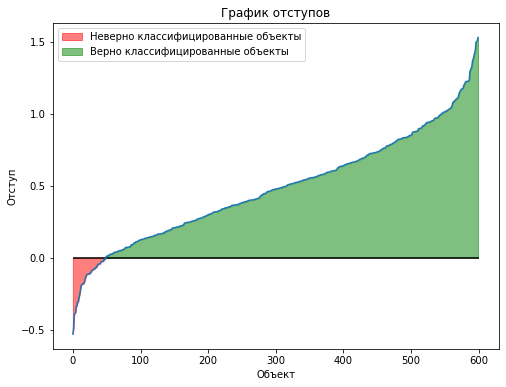

In [309]:
x = list(range(len(M)))
plt.figure(figsize = (8, 6))
plt.title('График отступов')
plt.xlabel('Объект')
plt.ylabel('Отступ')
plt.plot(x, M)

plt.hlines(0, 0, len(x), color = 'black')
plt.fill_between(x, M, where = M<0, color = 'red', alpha = 0.5, label = 'Неверно классифицированные объекты')
plt.fill_between(x, M, where = M>0, color = 'green', alpha = 0.5, label = 'Верно классифицированные объекты')
#plt.xlim(0, 300)
plt.legend()
plt.show()

В зависимости от ширины окна получаются разные результаты. При малой ширине окна (<5) практически нет ошибок, модель сильно переобучается. При ширине окна в диапазоне (10,20) кривая пересекает ноль под довольно большим углом, что говорит о малом количестве "пограничных" объектов и, как следствие, о более надежной классификации.

 <h3>Сравнение классификации на обучающей и тестовой выборках</h3>

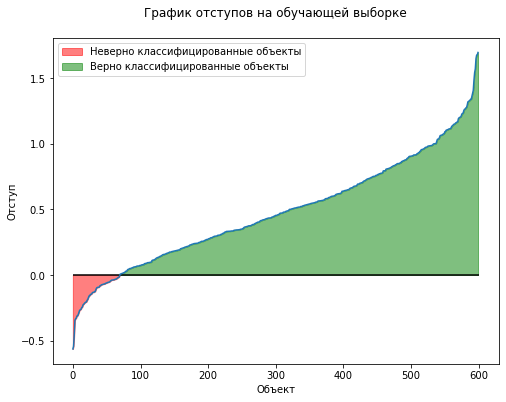

In [402]:
model = PFM(kernel = lambda x: K_triangle(x, h = 20))
model.fit(X_train, Y_train)

M = [s[y] -s[y-1] for s, y in zip(model.score(X_train), Y_train.values)]
M = np.array(sorted(M)).reshape((len(M),))

x = list(range(len(M)))
plt.figure(figsize = (8, 6))
plt.title('График отступов на обучающей выборке\n')
plt.xlabel('Объект')
plt.ylabel('Отступ')
plt.plot(x, M)

plt.hlines(0, 0, len(x), color = 'black')
plt.fill_between(x, M, where = M<0, color = 'red', alpha = 0.5, label = 'Неверно классифицированные объекты')
plt.fill_between(x, M, where = M>0, color = 'green', alpha = 0.5, label = 'Верно классифицированные объекты')
#plt.xlim(150, 500)
plt.legend()
plt.show()

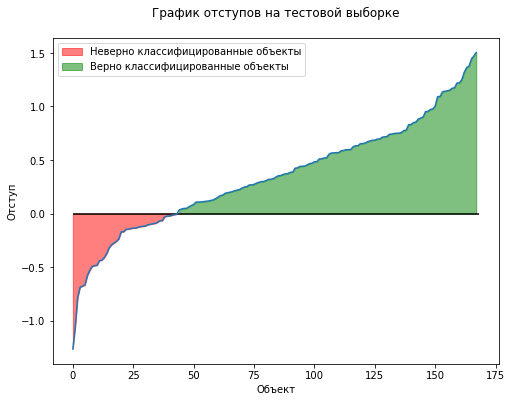

In [403]:
M_test = [s[y] - s[y-1] for s, y in zip(model.score(X_test), Y_test.values)]
M_test = np.array(sorted(M_test)).reshape((len(M_test),))

x = list(range(len(M_test)))
plt.figure(figsize = (8, 6))
plt.title('График отступов на тестовой выборке\n')
plt.xlabel('Объект')
plt.ylabel('Отступ')
plt.plot(x, M_test)

plt.hlines(0, 0, len(x), color = 'black')
plt.fill_between(x, M_test, where = M_test<0, color = 'red', alpha = 0.5, label = 'Неверно классифицированные объекты')
plt.fill_between(x, M_test, where = M_test>0, color = 'green', alpha = 0.5, label = 'Верно классифицированные объекты')
#plt.xlim(150, 500)
plt.legend()
plt.show()

Accuracy = 0.74
ROC AUC = 0.712059064807219


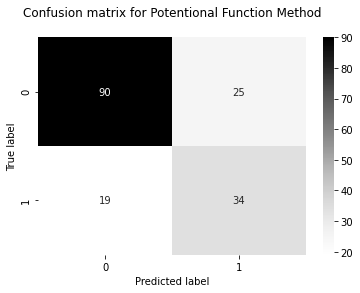

In [404]:
# Предсказания на тестовой выборке
y_pred = [ s for s in model.predict(X_test)]
conf_matrix = confusion_matrix(Y_test, y_pred, labels = [0,1])

p = sns.heatmap(conf_matrix, annot = True, cmap = 'Greys')
p.set_xlabel('Predicted label')
p.set_ylabel('True label')
p.set_title('Confusion matrix for Potentional Function Method\n')
print('Accuracy =', np.round(accuracy_score(Y_test, y_pred), 2))
print('ROC AUC =', roc_auc_score(Y_test, y_pred))

<h3>Подбор ширины окна для максимизации AUC на тестовой выборке</h3>

<h4>Сначала зафиксирую тип ядра. Тип ядра: треугольное, подбираю h в диапазоне [1, 99] </h4>

In [405]:
%%time
results = dict()
h_list = np.arange(1, 100)
# Для разной ширины окна считаю roc_auc
for h in range(0, h_list.shape[0]):
    model = PFM(kernel = lambda x: K_triangle(x, h = h_list[h]))
    model.fit(X_train, Y_train)
    y_pred = [ s for s in model.predict(X_test)]
    results[h_list[h]] = roc_auc_score(Y_test, y_pred)

Wall time: 45.9 s


<ipython-input-444-546b8e5ab0fc>:11: MatplotlibDeprecationWarning: The parameter where must have the same size as x in fill_between(). This will become an error in future versions of Matplotlib.
  plt.fill_between(x, y, where = list(y) > [0] , color = 'red', alpha = 0.4)


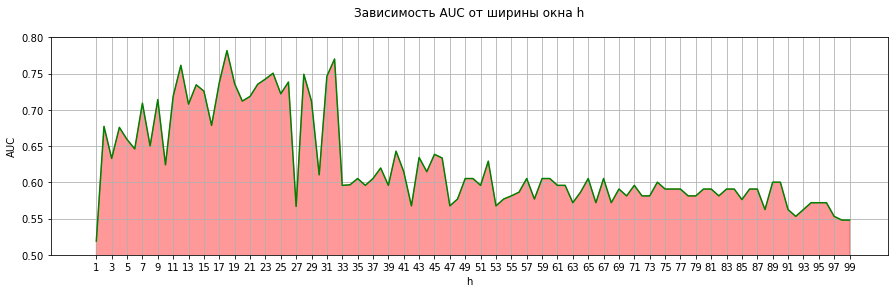

Max AUC:  0.7817063166529943


In [444]:
lists = results.items()
x, y = zip(*lists)
plt.figure(figsize = (15, 4))
plt.plot(x,y, c='green')
plt.title('Зависимость AUC от ширины окна h\n')
plt.xlabel('h')
plt.ylabel('AUC')
plt.xticks(range(1, 100, 2))
plt.ylim(0.5, 0.8)
plt.hlines(0, 0, len(x), color = 'black')
plt.fill_between(x, y, where = list(y) > [0] , color = 'red', alpha = 0.4)
plt.grid()
plt.show()
print('Max AUC: ', max(y))

<h4>Тип ядра: гауссовское, подбираю ширину окна</h4>

In [456]:
%%time
results = dict()
h_list = np.arange(1, 100)
# Для разной ширины окна считаю roc_auc
for h in range(0, h_list.shape[0]):
    model = PFM(kernel = lambda x: K_gauss(x, h = h_list[h]))
    model.fit(X_train, Y_train)
    y_pred = [ s for s in model.predict(X_test)]
    results[h_list[h]] = roc_auc_score(Y_test, y_pred)

Wall time: 45 s


<ipython-input-460-1bae7302cb8e>:11: MatplotlibDeprecationWarning: The parameter where must have the same size as x in fill_between(). This will become an error in future versions of Matplotlib.
  plt.fill_between(x, y, where = list(y) > [0] , color = 'red', alpha = 0.4)


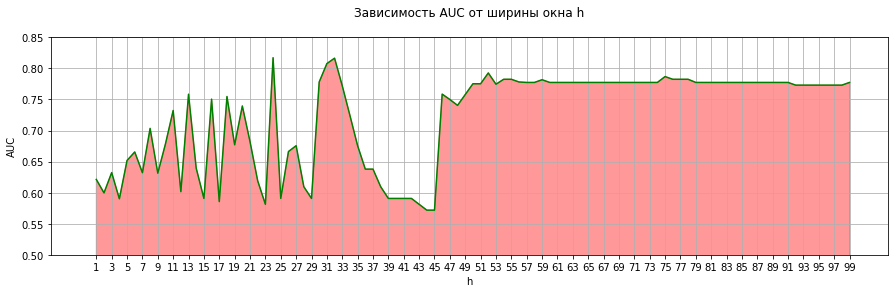

Max AUC:  0.8172272354388843


In [460]:
lists = results.items()
x, y = zip(*lists)
plt.figure(figsize = (15, 4))
plt.plot(x,y, c='green')
plt.title('Зависимость AUC от ширины окна h\n')
plt.xlabel('h')
plt.ylabel('AUC')
plt.xticks(range(1, 100, 2))
plt.ylim(0.5, 0.85)
plt.hlines(0, 0, len(x), color = 'black')
plt.fill_between(x, y, where = list(y) > [0] , color = 'red', alpha = 0.4)
plt.grid()
plt.show()
print('Max AUC: ', max(y))

<h4>Тип ядра: квадратичное, подбираю ширину окна</h4>

In [449]:
%%time
results = dict()
h_list = np.arange(1, 100)
# Для разной ширины окна считаю roc_auc
for h in range(0, h_list.shape[0]):
    model = PFM(kernel = lambda x: K(x, h = h_list[h]))
    model.fit(X_train, Y_train)
    y_pred = [ s for s in model.predict(X_test)]
    results[h_list[h]] = roc_auc_score(Y_test, y_pred)

Wall time: 46.8 s


<ipython-input-452-1bae7302cb8e>:11: MatplotlibDeprecationWarning: The parameter where must have the same size as x in fill_between(). This will become an error in future versions of Matplotlib.
  plt.fill_between(x, y, where = list(y) > [0] , color = 'red', alpha = 0.4)


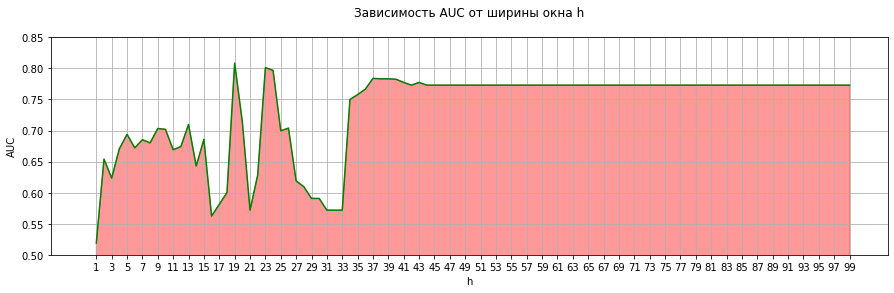

Max AUC:  0.8085315832649714


In [452]:
lists = results.items()
x, y = zip(*lists)
plt.figure(figsize = (15, 4))
plt.plot(x,y, c='green')
plt.title('Зависимость AUC от ширины окна h\n')
plt.xlabel('h')
plt.ylabel('AUC')
plt.xticks(range(1, 100, 2))
plt.ylim(0.5, 0.85)
plt.hlines(0, 0, len(x), color = 'black')
plt.fill_between(x, y, where = list(y) > [0] , color = 'red', alpha = 0.4)
plt.grid()
plt.show()
print('Max AUC: ', max(y))

<h3>Вывод</h3>

Метод потенциальных функций на отложенном тесте показал лучший результат со следующими параметрами:
<ul>
    <li>Тип ядра: гауссовское(инфинитное)</li>
    <li>Ширина окна: 24</li>
</ul>
AUC: 0.817

Метод потенциальных функций справился хуже чем логистическая регрессия и SVM, но лучше чем метод окна Парзена.
С помощью данного метода можно решать задачу отбора эталонов, чтобы сократить размер выборки, не теряя при этом в качестве 